In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

#**Loading The Data**

In [3]:
Train=pd.read_csv('https://raw.githubusercontent.com/NJSal/bigmart/main/train.csv')
Train_datavisual = Train
Test=pd.read_csv('https://raw.githubusercontent.com/NJSal/bigmart/main/test.csv')

In [4]:
Train.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
Test.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


#**Data Prelimany: Exploratory and Visualization**

##1.Distribution of Data Types








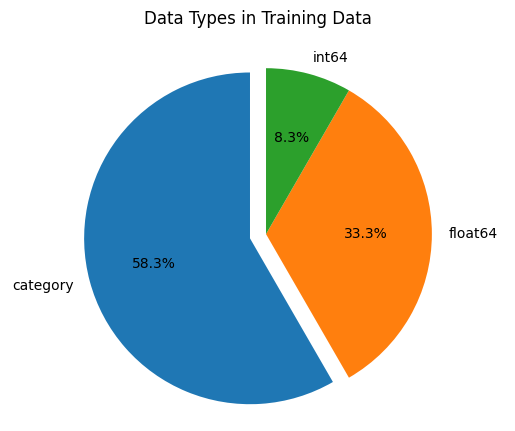

Data Types:
- Categorical: 7 columns
- Float: 4 columns
- Integer: 1 columns


In [6]:
arraytypes = Train.dtypes.unique()

dat_types = [dat_type.name for dat_type in arraytypes]
counts = [len(Train.select_dtypes(data_t).iloc[0]) for data_t in dat_types]

explode = [0.1 if dtype == 'object' else 0 for dtype in dat_types]    #assign 0.1 when dtype = 'object' else assign 0 


dtypes = [name if name != 'object' else 'category' for name in dat_types]
fig1, ax1 = plt.subplots()

ax1.pie(counts, labels=dtypes, autopct='%1.1f%%', startangle=90, explode=explode)
ax1.axis('equal')

plt.title('Data Types in Training Data', pad=20)
plt.show()

array_t=Train.dtypes.unique()
print("Data Types:")

obj_Count=0
int_Count=0
flt_Count=0


for i in Train.dtypes: 
    if i.name == "object":
      obj_Count = obj_Count + 1
    if i.name == "int64":
      int_Count = int_Count + 1
    if i.name == "float64":
      flt_Count = flt_Count + 1

for atype in Train.dtypes.unique(): 
  if atype.name == "object":
    print("-", "Categorical:", obj_Count, "columns")
  if atype.name == "float64": 
    print("-", "Float:", flt_Count, "columns")
  if atype.name == "int64": 
    print("-", "Integer:", int_Count, "columns")
#print([atype.name for atype in array_t])

##2.Outlet Type, Fat Content, and Year of Establishment and Relationship with OutletSales in Training Data

###1.Outlet Type vs Outlet Sales

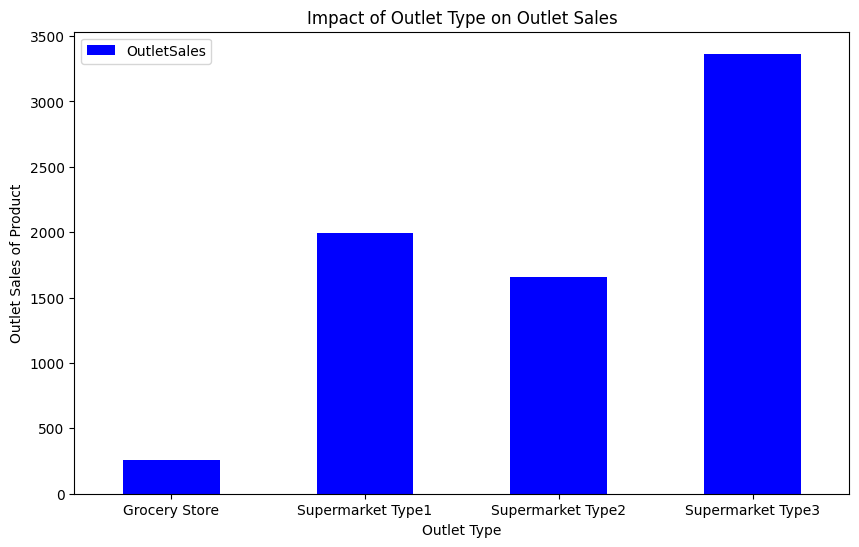

In [7]:
outlettype_outletsales = Train.pivot_table(index='OutletType', values="OutletSales", aggfunc=np.median)       #median values get displayed (in other words, the middle values) 

outlettype_outletsales.plot(kind='bar',color='blue',figsize=(10,6))
plt.xlabel("Outlet Type")
plt.ylabel("Outlet Sales of Product")
plt.title("Impact of Outlet Type on Outlet Sales")
plt.xticks(rotation=0)
plt.show()

###2.Fat Content vs Outlet Sales 

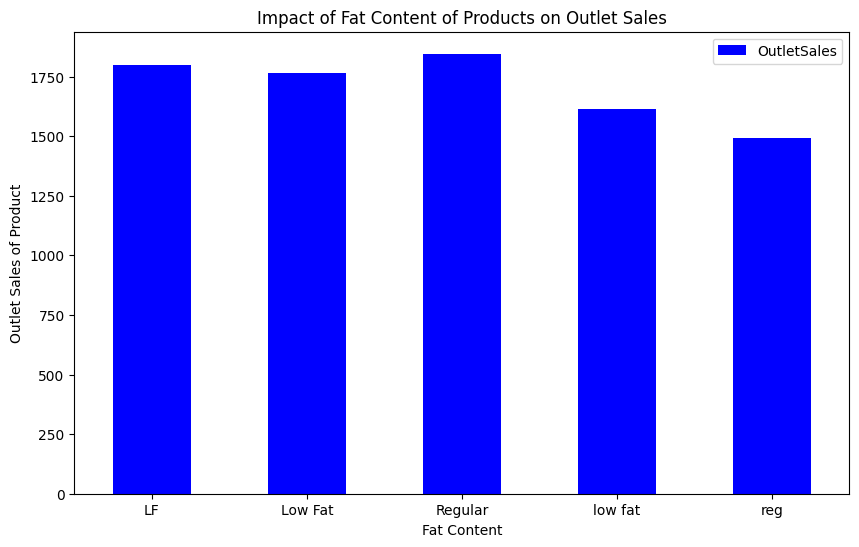

In [8]:
fatcontent_outletsales = Train.pivot_table(index='FatContent', values="OutletSales", aggfunc=np.median)      #median values get displayed (in other words, the middle values) 

fatcontent_outletsales.plot(kind='bar',color='blue',figsize=(10,6))
plt.xlabel("Fat Content")
plt.ylabel("Outlet Sales of Product")
plt.title("Impact of Fat Content of Products on Outlet Sales")
plt.xticks(rotation=0)
plt.show()

###3.Year of Establish vs Outlet Sales

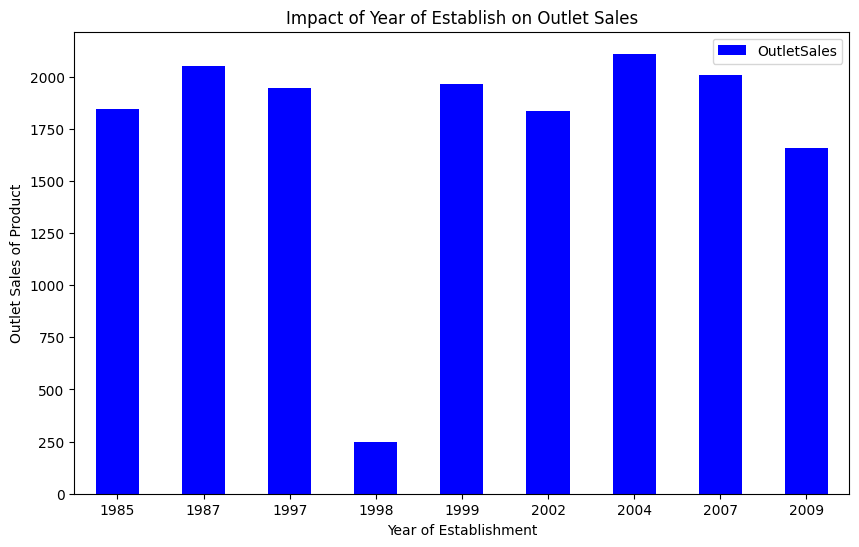

In [9]:
estyear_outletsales = Train.pivot_table(index='EstablishmentYear', values="OutletSales", aggfunc=np.median)          #median outletsales values get displayed (in other words, the middle values) 

estyear_outletsales.plot(kind='bar',color='blue',figsize=(10,6))
plt.xlabel("Year of Establishment")
plt.ylabel("Outlet Sales of Product")
plt.title("Impact of Year of Establish on Outlet Sales")
plt.xticks(rotation=0)
plt.show()

###4.Amount of Product vs Product Type

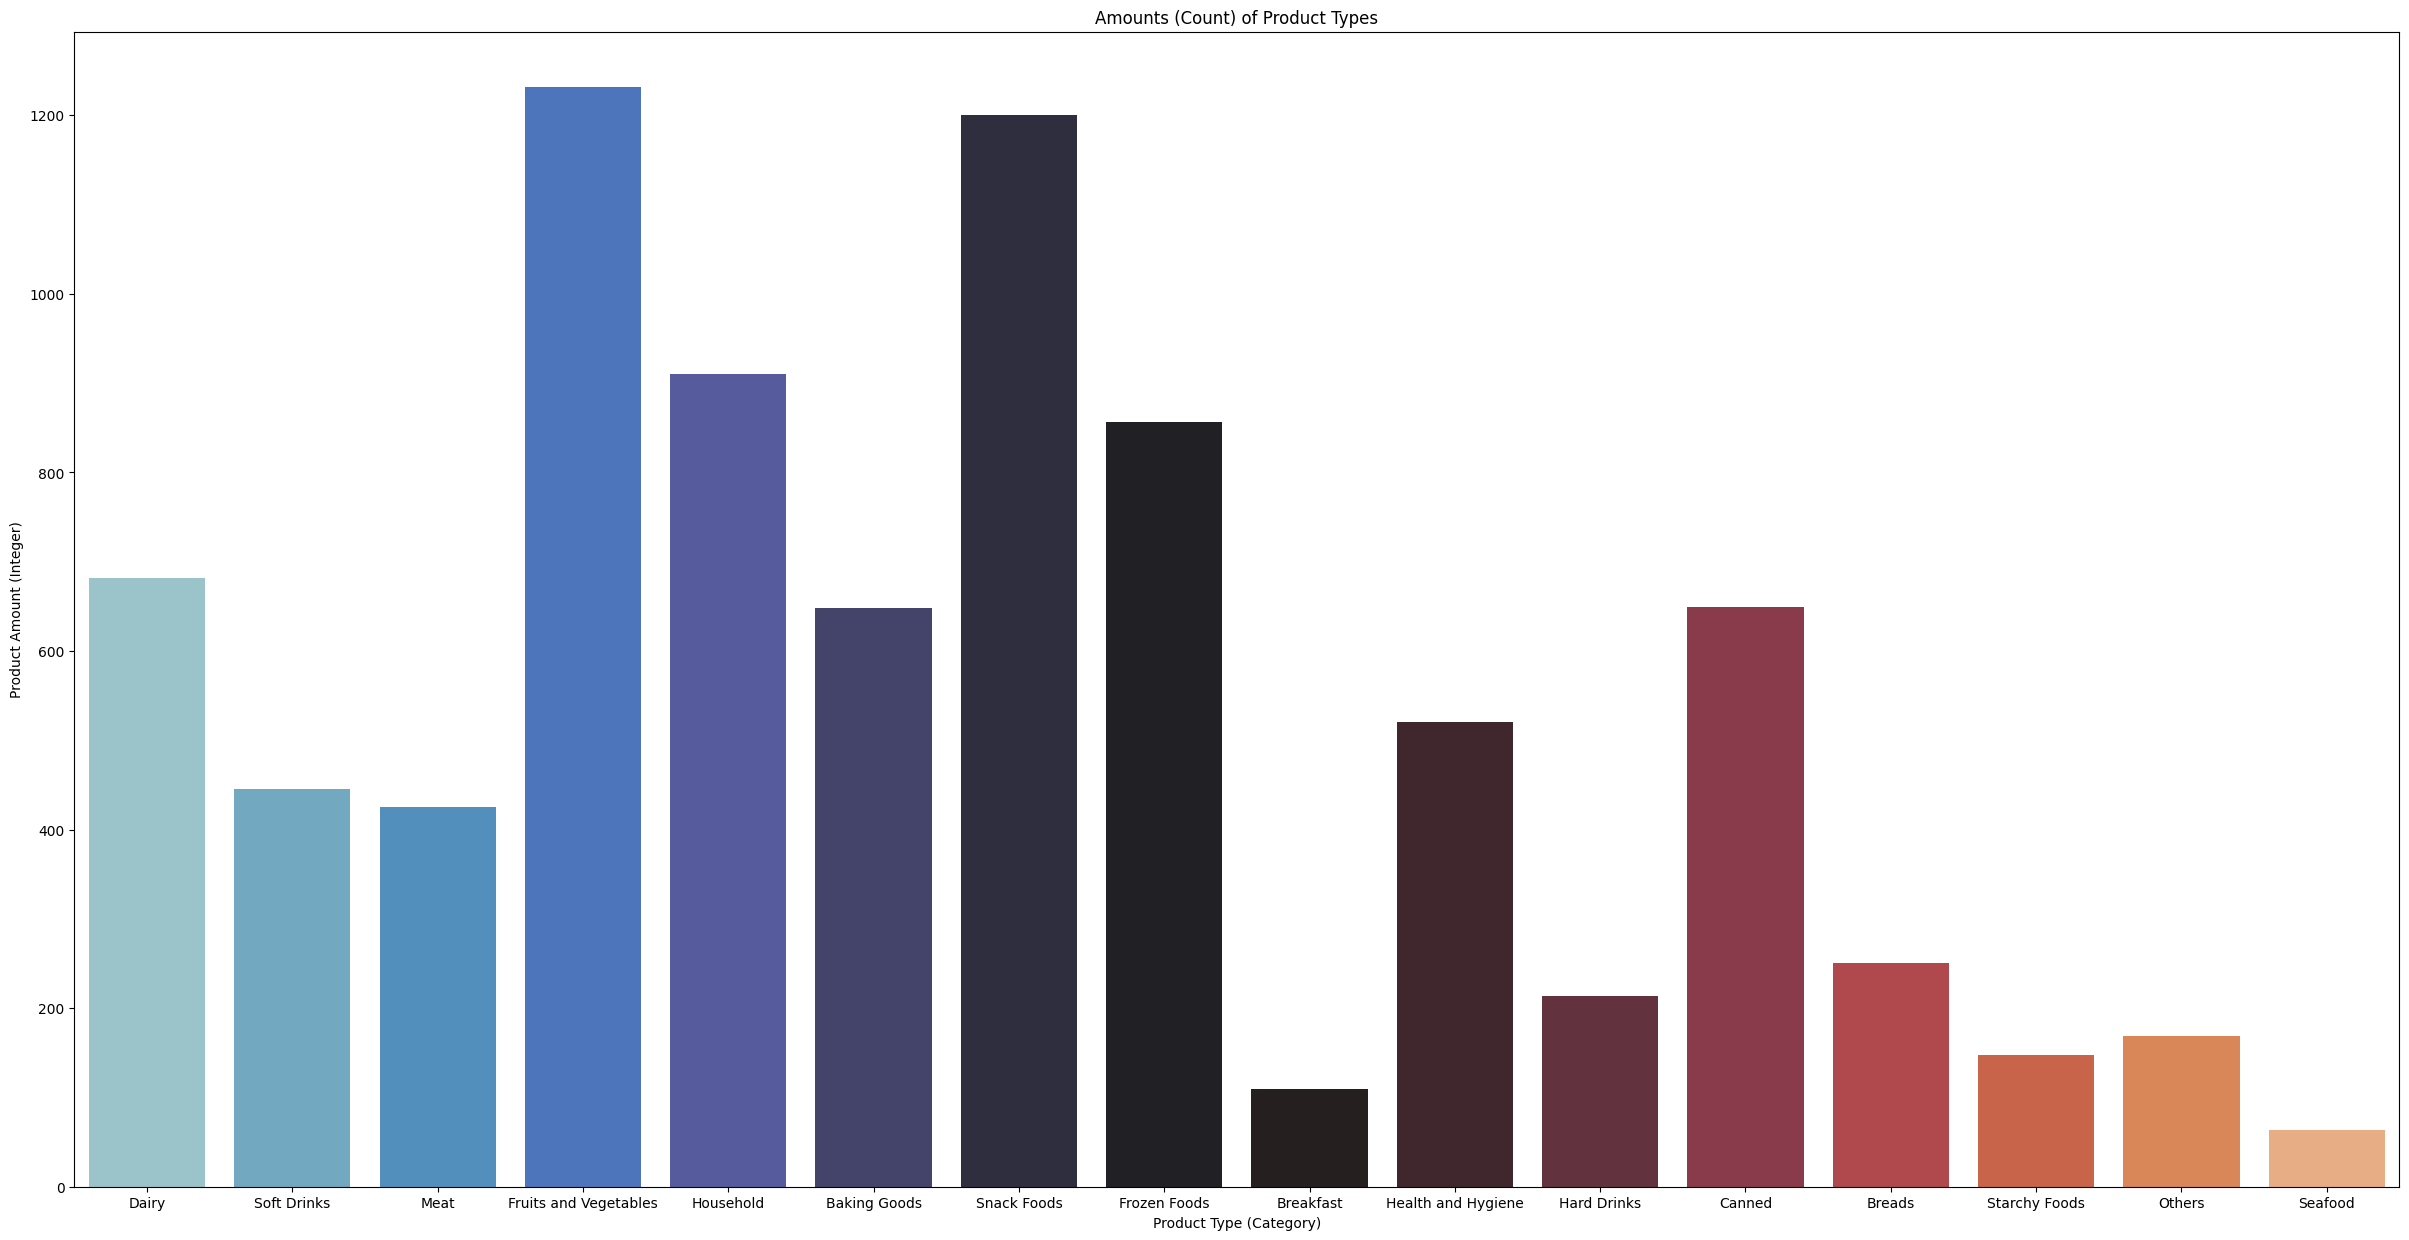

In [10]:
plt.figure(figsize=(30,15))
#sns.set_theme(style="whitegrid")
#sns.color_palette("husl", 8)
sns.countplot(data=Train, x='ProductType', palette="icefire").set_title('Amounts (Count) of Product Types')
plt.xlabel('Product Type (Category)')
plt.ylabel('Product Amount (Integer)')
plt.show()

#**Data Preprocessing: Cleaning, and Encoding**

##1.Checking for Columns with Null values

In [11]:
Train.isnull().sum()

ProductID               0
Weight               1463
FatContent              0
ProductVisibility       0
ProductType             0
MRP                     0
OutletID                0
EstablishmentYear       0
OutletSize           2410
LocationType            0
OutletType              0
OutletSales             0
dtype: int64

##2.Data Distribution for Columns with Null Values After Performing Data Cleaning

###Weight and OutletSize (Columns that require cleaning)

In [12]:
Train['Weight'].fillna(Train['Weight'].mean(), inplace=True)

In [13]:
Train_datavisual['OutletSize'].fillna('Medium', inplace=True)

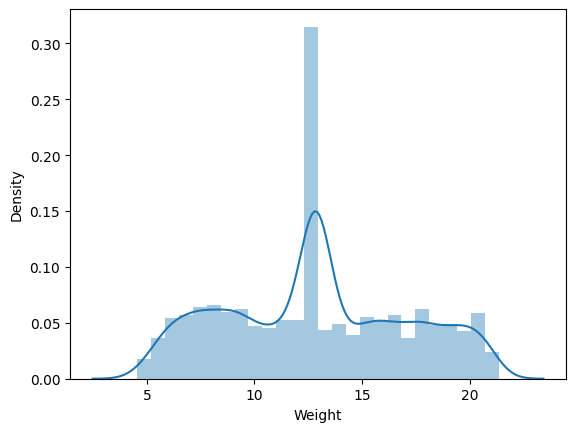

In [14]:
sns.distplot(Train["Weight"])
plt.show()

In [15]:
encoder = LabelEncoder()

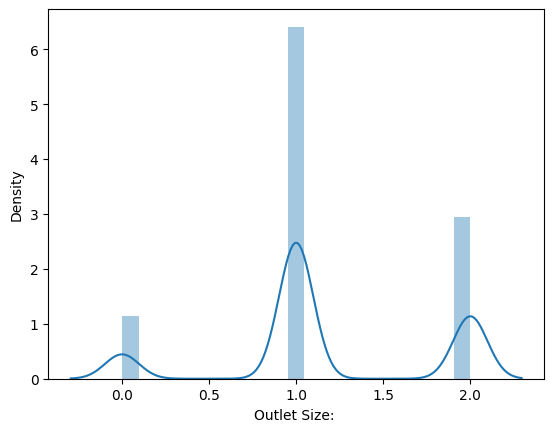

In [16]:
encoded_OutletSize = encoder.fit_transform(Train_datavisual['OutletSize'])


sns.distplot(encoded_OutletSize)
plt.xlabel("Outlet Size: ")
plt.show()

###Data Cleaning Complete

In [17]:
Train['Weight'].fillna(Train['Weight'].mean(), inplace=True)
Train['OutletSize'].fillna('Medium', inplace=True)

In [18]:
Train.isnull().sum()

ProductID            0
Weight               0
FatContent           0
ProductVisibility    0
ProductType          0
MRP                  0
OutletID             0
EstablishmentYear    0
OutletSize           0
LocationType         0
OutletType           0
OutletSales          0
dtype: int64

###Data Encoding and Distribution of Data After Data Cleaning

####Label Encoding: the encoding technique of choice for this project

In [19]:
Train['FatContent'] = encoder.fit_transform(Train['FatContent'])
Train['ProductType'] = encoder.fit_transform(Train['ProductType'])
Train['OutletSize'] = encoder.fit_transform(Train['OutletSize'])
encoded_OutletSize = encoder.fit_transform(Train['OutletSize'])
Train['LocationType'] = encoder.fit_transform(Train['LocationType'])
Train['OutletType'] = encoder.fit_transform(Train['OutletType'])
Train['OutletID'] = encoder.fit_transform(Train['OutletID'])
Train['ProductID'] = encoder.fit_transform(Train['ProductID'])

In [20]:
Test['FatContent'] = encoder.fit_transform(Test['FatContent'])
Test['ProductType'] = encoder.fit_transform(Test['ProductType'])
Test['OutletSize'] = encoder.fit_transform(Test['OutletSize'])
Test['LocationType'] = encoder.fit_transform(Test['LocationType'])
Test['OutletType'] = encoder.fit_transform(Test['OutletType'])
Test['ProductType'] = encoder.fit_transform(Test['OutletType'])

In [21]:
Test

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType
0,FDW58,20.750,1,0.007565,1,107.8622,OUT049,1999,1,0,1
1,FDW14,8.300,4,0.038428,1,87.3198,OUT017,2007,3,1,1
2,NCN55,14.600,1,0.099575,0,241.7538,OUT010,1998,3,2,0
3,FDQ58,7.315,1,0.015388,1,155.0340,OUT017,2007,3,1,1
4,FDY38,NaN,2,0.118599,3,234.2300,OUT027,1985,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,2,0.013496,1,141.3154,OUT046,1997,2,0,1
5677,FDD47,7.600,2,0.142991,2,169.1448,OUT018,2009,1,2,2
5678,NCO17,10.000,1,0.073529,1,118.7440,OUT045,2002,3,1,1
5679,FDJ26,15.300,2,0.000000,1,214.6218,OUT017,2007,3,1,1


In [22]:
Train

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales
0,156,9.300,1,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.920,2,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.500,1,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.200,2,0.000000,6,182.0950,0,1998,1,2,0,732.3800
4,1297,8.930,1,0.000000,9,53.8614,1,1987,0,2,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,370,6.865,1,0.056783,13,214.5218,1,1987,0,2,1,2778.3834
8519,897,8.380,2,0.046982,0,108.1570,7,2002,1,1,1,549.2850
8520,1357,10.600,1,0.035186,8,85.1224,6,2004,2,1,1,1193.1136
8521,681,7.210,2,0.145221,13,103.1332,3,2009,1,2,2,1845.5976


##3.Data Visualization (After Cleaning and Label Encoding)

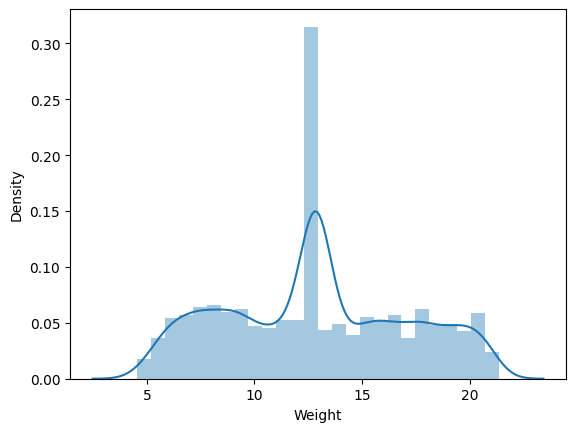

In [23]:
sns.distplot(Train["Weight"])
plt.show()

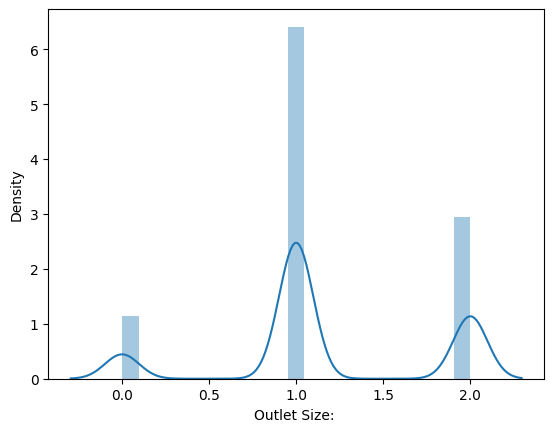

In [24]:
Train_datavisual["OutletSize"] = encoded_OutletSize

Train_datavisual

sns.distplot(Train_datavisual["OutletSize"])
#sns.set_theme(style="white")
plt.xlabel("Outlet Size: ")
plt.show()

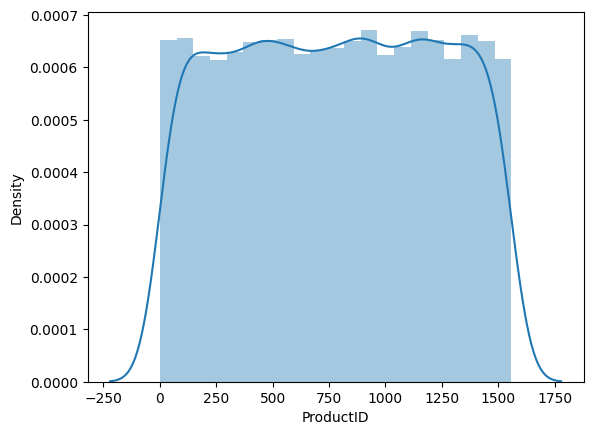

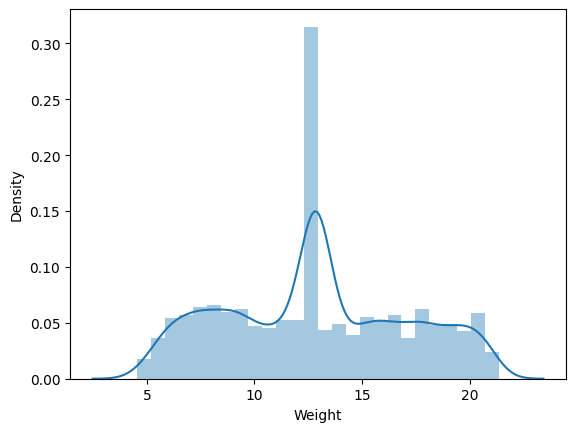

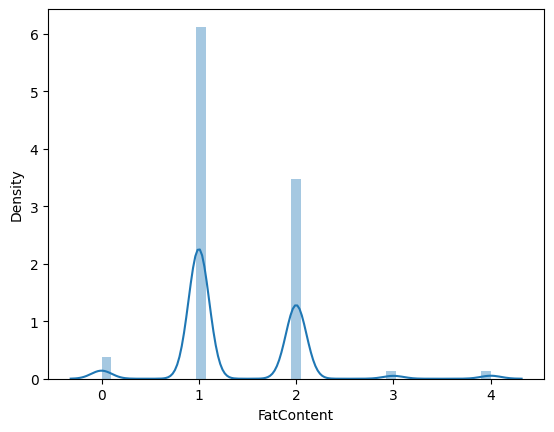

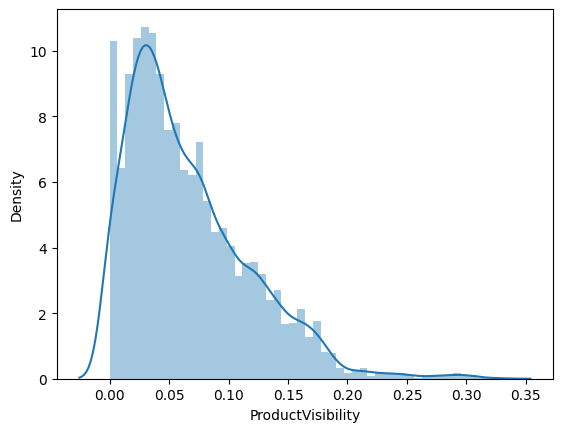

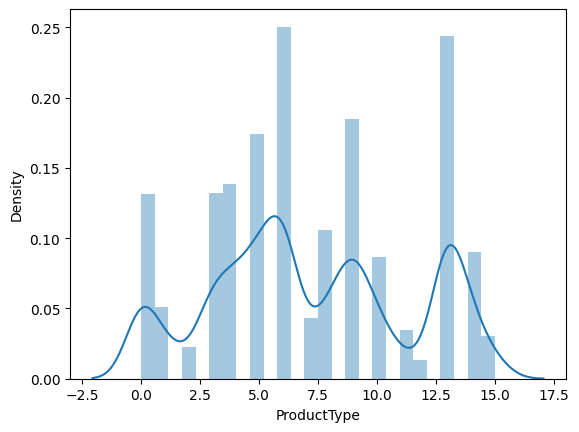

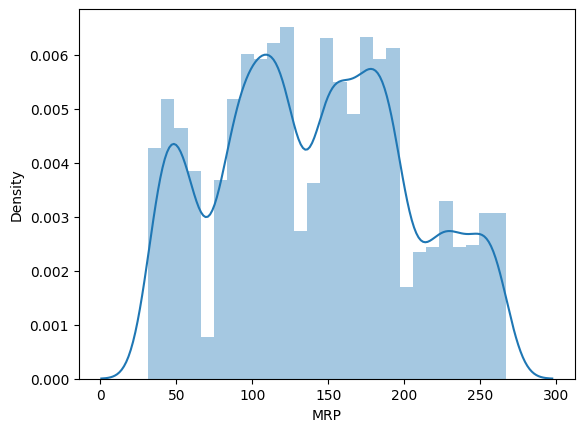

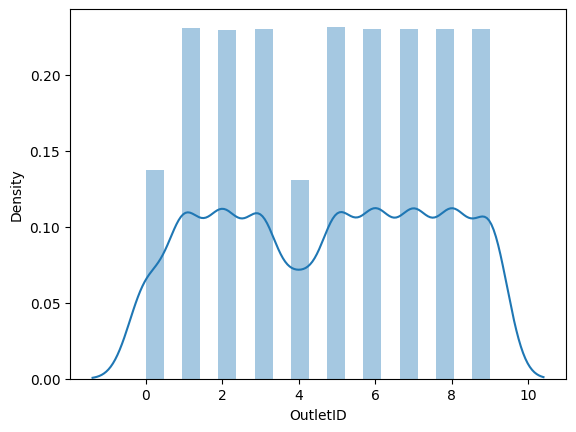

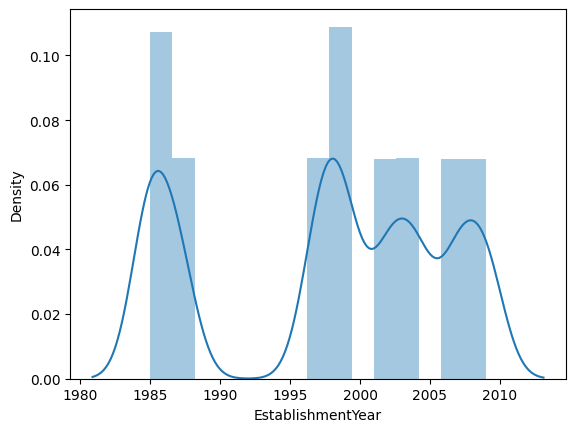

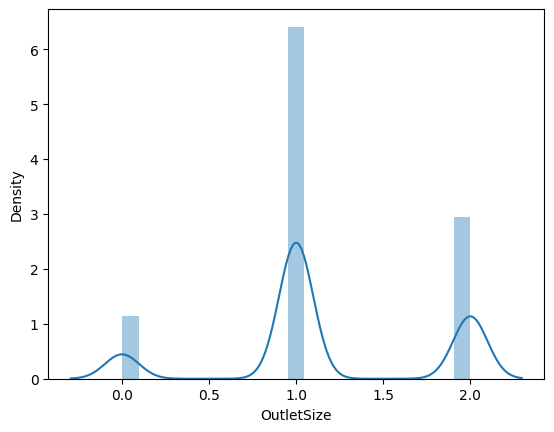

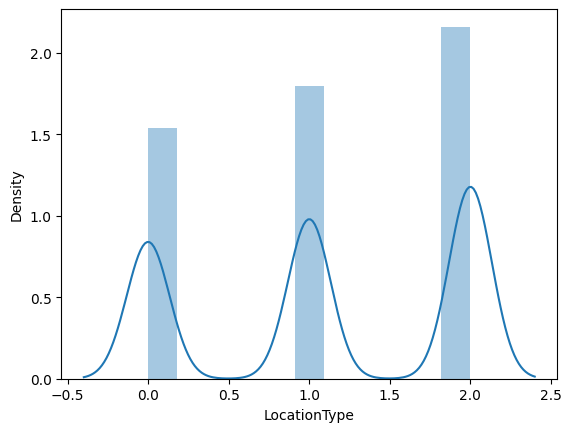

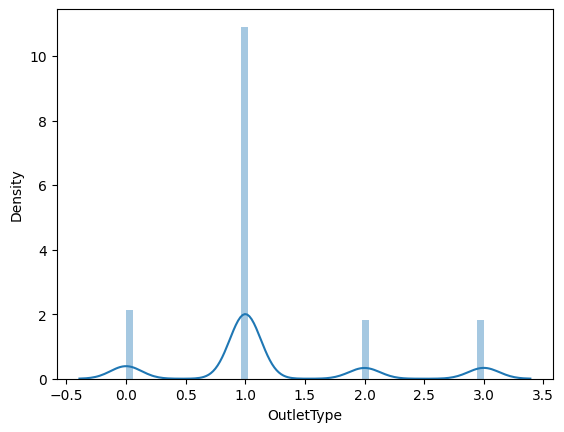

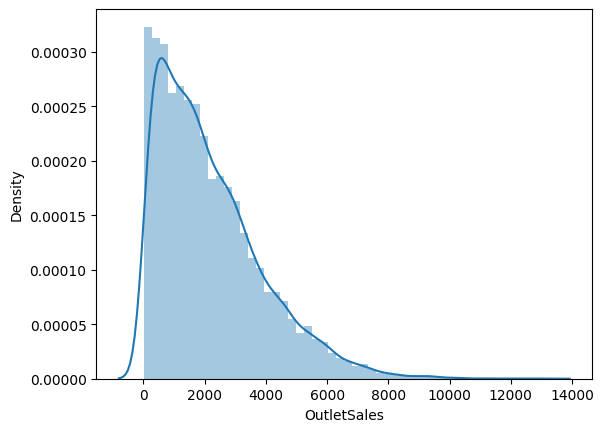

In [25]:
for i in Train.describe().columns:
  sns.distplot(Train[i].dropna())
  plt.show()

##4.Model Selection and Training

In [26]:
X = Train.drop(columns=['ProductID','ProductType','OutletID', 'OutletSales'])
y = Train['OutletSales']

In [27]:
X_test = Test.drop(columns=['ProductID','ProductType','OutletID'])

In [28]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state=2)
print(X.shape,X_train.shape,X_test.shape)

(8523, 8) (6818, 8) (5681, 8)


In [29]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [30]:
print(lr.score(X_train,y_train))

0.5118233726646275


In [31]:
y_pred = lr.predict(X_val)

mse = metrics.mean_squared_error(y_val,y_pred)
mas = metrics.mean_absolute_error(y_val,y_pred)

print("\nRoot Mean Squared Error : ",(mse)**0.5)
print("\nMean Absolute Error : ",mas)


Root Mean Squared Error :  1252.763943843173

Mean Absolute Error :  940.3099474277486


In [32]:

lasso_parameters = {
  'alpha': np.arange(0.01, 1.0, 0.01)
 }
lasso = Lasso()
clf = GridSearchCV(lasso,lasso_parameters,cv = 10)
clf.fit(X_train,y_train)
print("\n The best estimator :",clf.best_estimator_)
print("\n The best parameters :",clf.best_params_)   
   # add the clf to the estimators list


 The best estimator : Lasso(alpha=0.01)

 The best parameters : {'alpha': 0.01}


In [33]:
print("The best score :",clf.best_score_) 

The best score : 0.5095576903826892


In [34]:
las = Lasso(alpha=0.01)
las.fit(X_train,y_train)

Lasso(alpha=0.01)

In [35]:
y_pred = las.predict(X_val)

mse = metrics.mean_squared_error(y_val,y_pred)
mas = metrics.mean_absolute_error(y_val,y_pred)

print("\nRoot Mean Squared Error : ",(mse)**0.5)
print("\nMean Absolute Error : ",mas)


Root Mean Squared Error :  1252.7701423458514

Mean Absolute Error :  940.315451884976


In [36]:
# Define the hyperparameters to tune
hyperparameters = {'n_estimators': [50, 100, 200],
                   'max_depth': [5, 10, None],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'max_features': ['sqrt', 'log2']}

# Create a random forest regressor object
rfr = RandomForestRegressor()

# Perform a grid search over the hyperparameters
clf = GridSearchCV(rfr, hyperparameters, cv=5)
clf.fit(X_train, y_train)

# Print the best parameters and the corresponding mean cross-validated score
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best score: 0.5977019882043472


In [37]:
rfr = RandomForestRegressor(max_depth= 10, max_features='log2', min_samples_leaf= 4, min_samples_split=2, n_estimators=200)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=4,
                      n_estimators=200)

In [38]:
y_pred = rfr.predict(X_val)

mse = metrics.mean_squared_error(y_val,y_pred)
mas = metrics.mean_absolute_error(y_val,y_pred)

print("\nRoot Mean Squared Error : ",(mse)**0.5)
print("\nMean Absolute Error : ",mas)


Root Mean Squared Error :  1135.6257199770778

Mean Absolute Error :  792.3401080506837


In [39]:
hyperparameters = {'max_depth': [2, 4, 6, 8, 10, 12, None],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'max_features': ['sqrt', 'log2']}

# Create a decision tree regressor object
dtr = DecisionTreeRegressor()

# Perform a grid search over the hyperparameters
clf = GridSearchCV(dtr, hyperparameters, cv=5)
clf.fit(X_train, y_train)

# Print the best parameters and the corresponding mean cross-validated score
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

Best parameters: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score: 0.5647650773062335


In [40]:
dtr = DecisionTreeRegressor(max_depth= 8, max_features= 'log2', min_samples_leaf= 4, min_samples_split= 10)
dtr.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=8, max_features='log2', min_samples_leaf=4,
                      min_samples_split=10)

In [41]:
y_pred = dtr.predict(X_val)

mse = metrics.mean_squared_error(y_val,y_pred)
mas = metrics.mean_absolute_error(y_val,y_pred)

print("\nRoot Mean Squared Error : ",(mse)**0.5)
print("\nMean Absolute Error : ",mas)


Root Mean Squared Error :  1169.1881680362824

Mean Absolute Error :  816.3624878639258


In [42]:
ridge_parameters = {
  'alpha': np.arange(0.01, 1.0, 0.01)
 }
ridge=Ridge()
clf = GridSearchCV(ridge,ridge_parameters,cv = 10)
clf.fit(X_train,y_train)
print("\n The best estimator across ALL searched params:\n",clf.best_estimator_)
print("\n The best parameters across ALL searched params:\n",clf.best_params_)



 The best estimator across ALL searched params:
 Ridge(alpha=0.77)

 The best parameters across ALL searched params:
 {'alpha': 0.77}


In [43]:
rd = Ridge(alpha=0.77)
rd.fit(X_train,y_train)

Ridge(alpha=0.77)

In [44]:
y_pred = rd.predict(X_val)

mse = metrics.mean_squared_error(y_val,y_pred)
mas = metrics.mean_absolute_error(y_val,y_pred)

print("\nRoot Mean Squared Error : ",(mse)**0.5)
print("\nMean Absolute Error : ",mas)


Root Mean Squared Error :  1252.8454831344113

Mean Absolute Error :  940.3855973024937


In [45]:
hyperparameters = {'learning_rate': [0.01, 0.05, 0.1],
                   'max_depth': [2,4,6],
                   'n_estimators': [50, 100,200],
                   }

# Create an XGBRegressor object
xgb = XGBRegressor()

# Perform a grid search over the hyperparameters
clf = GridSearchCV(xgb, hyperparameters, cv=10)
clf.fit(X_train, y_train)

# Print the best parameters and the corresponding mean cross-validated score
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}
Best score: 0.6017528897809141


In [46]:
xgb = XGBRegressor(learning_rate= 0.05, max_depth=2, n_estimators=200)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
y_pred = xgb.predict(X_val)

mse = metrics.mean_squared_error(y_val,y_pred)
mas = metrics.mean_absolute_error(y_val,y_pred)

print("\nRoot Mean Squared Error : ",(mse)**0.5)
print("\nMean Absolute Error : ",mas)


Root Mean Squared Error :  1126.3039283157948

Mean Absolute Error :  786.3535072300285


In [48]:
hyperparameters = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                   'degree': [2,3,4,5],
                   }
svm = SVR()

# Perform a grid search over the hyperparameters
clf = GridSearchCV(svm, hyperparameters, cv=5)
clf.fit(X_train, y_train)

# Print the best parameters and the corresponding mean cross-validated score
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)


Best parameters: {'degree': 2, 'kernel': 'linear'}
Best score: 0.4654668857653347


In [49]:
svm = SVR(degree=2,kernel='linear')
svm.fit(X_train,y_train)

SVR(degree=2, kernel='linear')

In [50]:
y_pred = svm.predict(X_val)

mse = metrics.mean_squared_error(y_val,y_pred)
mas = metrics.mean_absolute_error(y_val,y_pred)

print("\nRoot Mean Squared Error : ",(mse)**0.5)
print("\nMean Absolute Error : ",mas)


Root Mean Squared Error :  1311.7499461309958

Mean Absolute Error :  961.6222835928794


In [51]:
y_test = xgb.predict(X_test)
y_test

array([1596.8286, 1464.472 ,  710.1761, ..., 1874.7006, 3593.3235,
       1298.8857], dtype=float32)